In [1]:
import encode_to_contact_utils as eutil
import util
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
CHROMOSOME = "chr10"
START = 13600000
RESOLUTION = 8000
PATCH_SIZE = 120
STOP = START + PATCH_SIZE * RESOLUTION
PATCH_NUM = 20
MODE = "mean"
DIAG_STOP = 60
MAIN_FOLDER = ".local/experiment_results"

In [3]:
map_h1, map_hff, encode_h1, encode_hff, signal_names = eutil.read_data(
                                        ".data/ForGrant/chr10_8k_H1.npy",
                                        ".data/ForGrant/chr10_8k_HFF.npy",
                                        ".data/ForGrant/bestTracksBinned.txt",
                                        "../loopExtraction/data/ctcf/MA0139.1.neg.score.sorted.bedgraph",
                                        "../loopExtraction/data/ctcf/MA0139.1.pos.score.sorted.bedgraph",
                                        MODE,
                                        CHROMOSOME,
                                        START,
                                        STOP,
                                        RESOLUTION)
signal_names = np.concatenate([signal_names, ["CTCF_neg", "CTCF_pos"]])

In [4]:
color_dict = eutil.assign_unique_colors(signal_names)

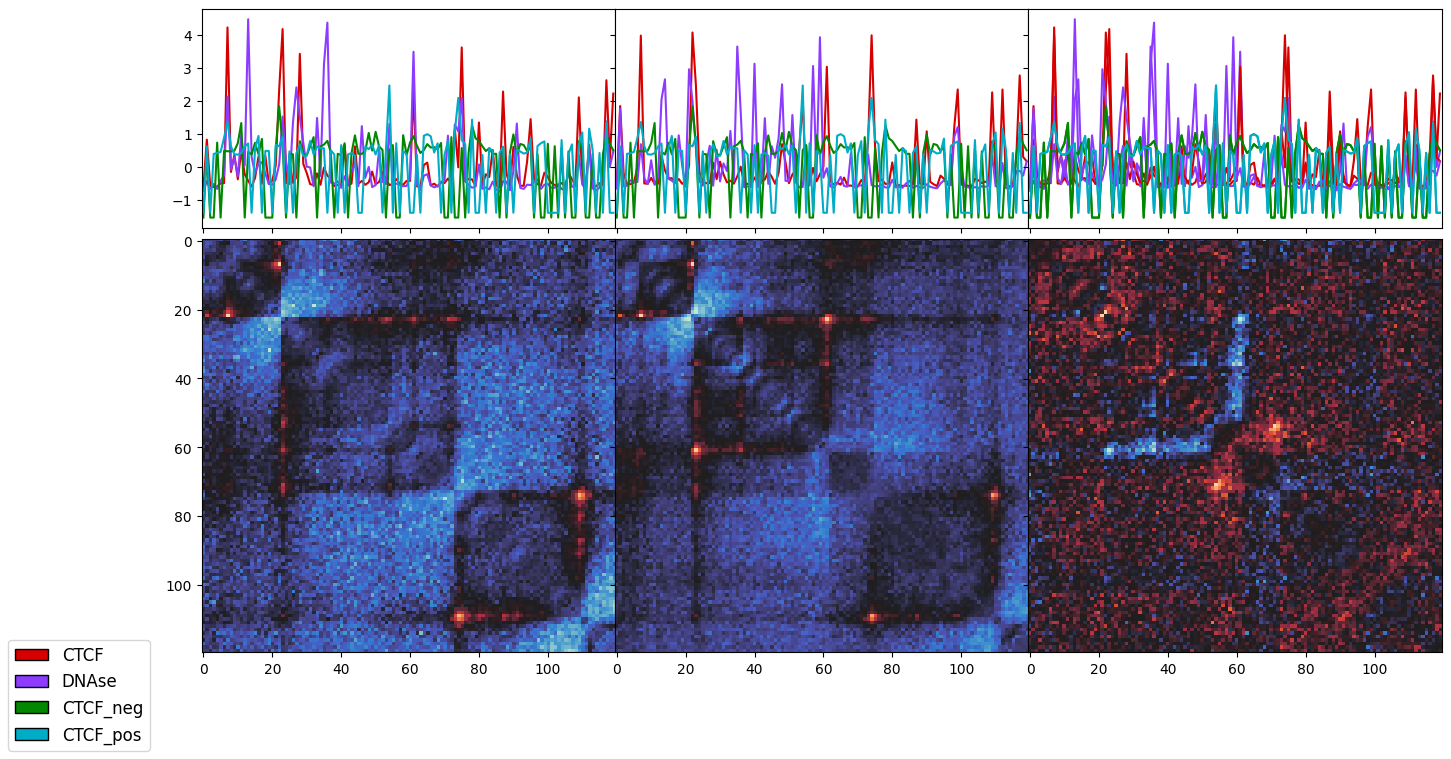

In [5]:
eutil.plot_map_diff(map_h1, map_hff, encode_h1, encode_hff, signal_names, signal_names, color_dict)

In [6]:
model = eutil.read_model(".local/best_corr_hfftoh1.pt", 120, 4)

In [9]:
total_param = 0
for p in model.parameters():
    total_param += p.numel()
total_param

573

In [7]:
map_h1 = torch.tensor(map_h1, dtype=torch.float32)
map_hff = torch.tensor(map_hff, dtype=torch.float32)
encode_h1 = torch.tensor(encode_h1, dtype=torch.float32)
encode_hff = torch.tensor(encode_hff, dtype=torch.float32)

/tmp/ipykernel_1031862/2985597754.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  map_h1 = torch.tensor(map_h1, dtype=torch.float32)
/tmp/ipykernel_1031862/2985597754.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  map_hff = torch.tensor(map_hff, dtype=torch.float32)


/data/src/loopextrusion_pytorch/util.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat = torch.tensor(mat)


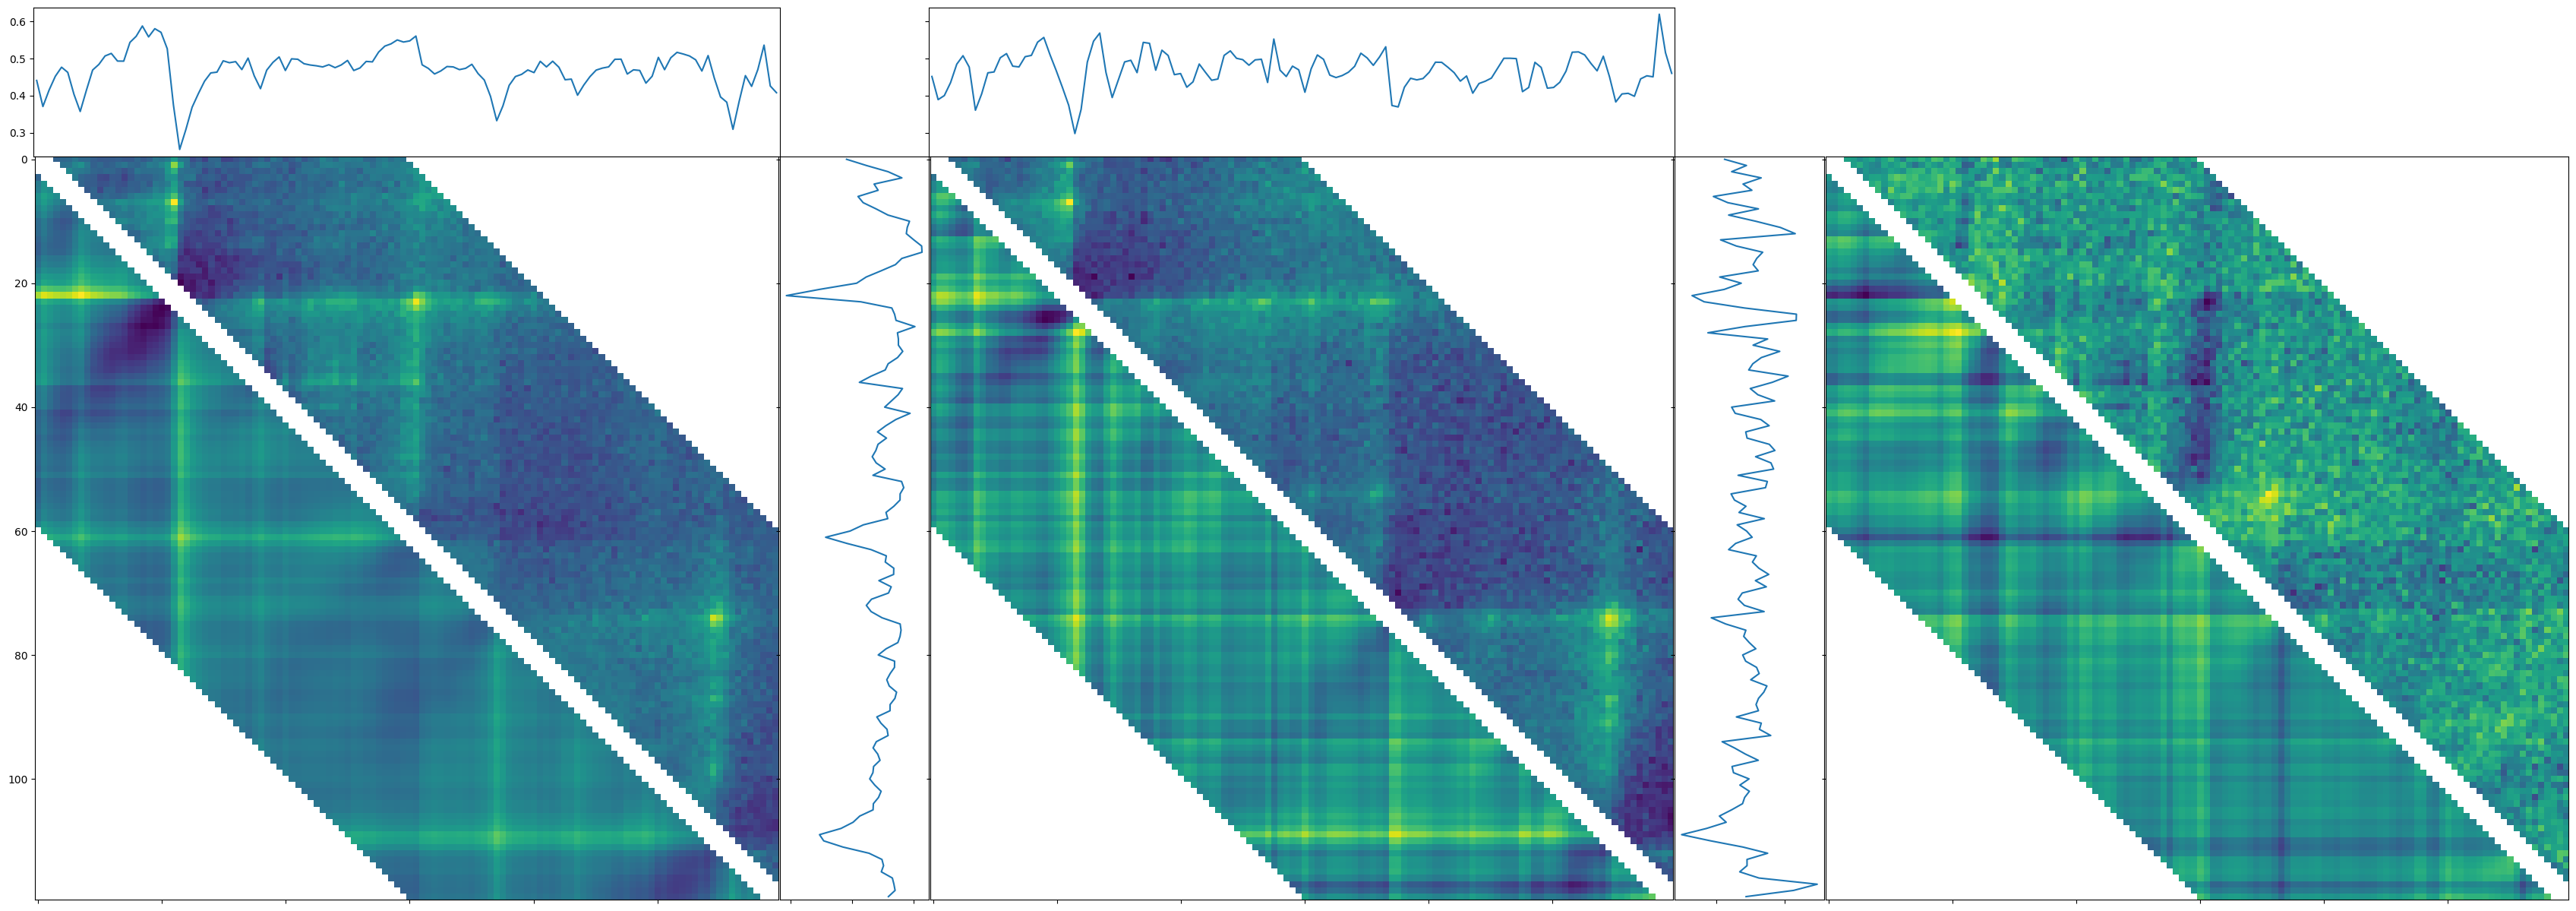

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(12 * 3,14),
                        sharex='col',
                        sharey='row',
                        gridspec_kw={'wspace':0,
                                    'hspace':0,
                                    'height_ratios':[10, 50, 10],
                                    'width_ratios':[50, 10]*3})


eutil.plot_results_comp_train_val(model,
                                 map_hff,
                                 map_h1,
                                 encode_hff,
                                 encode_h1,
                                 DIAG_STOP, 
                                 axes=axes)

In [9]:
pred_hff, p_l_train, p_r_train = eutil.return_model_result(model, encode_hff[None])
pred_h1, p_l_val, p_r_val = eutil.return_model_result(model, encode_h1[None])

In [10]:
origami_h1 = util.diagonal_normalize(torch.tensor(np.load(".data/ForGrant/origamiH1pPatch.npy"))[None])[0]
origami_hff = util.diagonal_normalize(torch.tensor(np.load(".data/ForGrant/origamiHFFPatch.npy"))[None])[0]
pred_h1 = util.diagonal_normalize(pred_h1[None])[0]
pred_hff = util.diagonal_normalize(pred_hff[None])[0]

In [11]:
map_diff = map_h1-map_hff
pred_diff = pred_h1-pred_hff
origami_diff = origami_h1-origami_hff

In [12]:
def plot_pred_data(patch, pred, ax, cmap=None):
    plot_mat = np.triu(patch) + np.triu(pred, 1).T
    util.plot_pred_data_on_same_ax(plot_mat, 3, 60, ax, cmap=cmap)

In [13]:
def make_ticks_invisible(ax):
    ax.tick_params(axis='both', which='both', color='none')
    ax.yaxis.set_tick_params(labelcolor='none')
    ax.xaxis.set_tick_params(labelcolor='none')

In [21]:
pred_corr = util.mat_corr(map_diff[util.diagonal_region_indices_from(map_diff, 3, 60)],
                          pred_diff[util.diagonal_region_indices_from(map_diff, 3, 60)])
origami_corr = util.mat_corr(map_diff[util.diagonal_region_indices_from(map_diff, 3, 60)],
                             origami_diff[util.diagonal_region_indices_from(map_diff, 3, 60)])

/tmp/ipykernel_1031862/3234227030.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


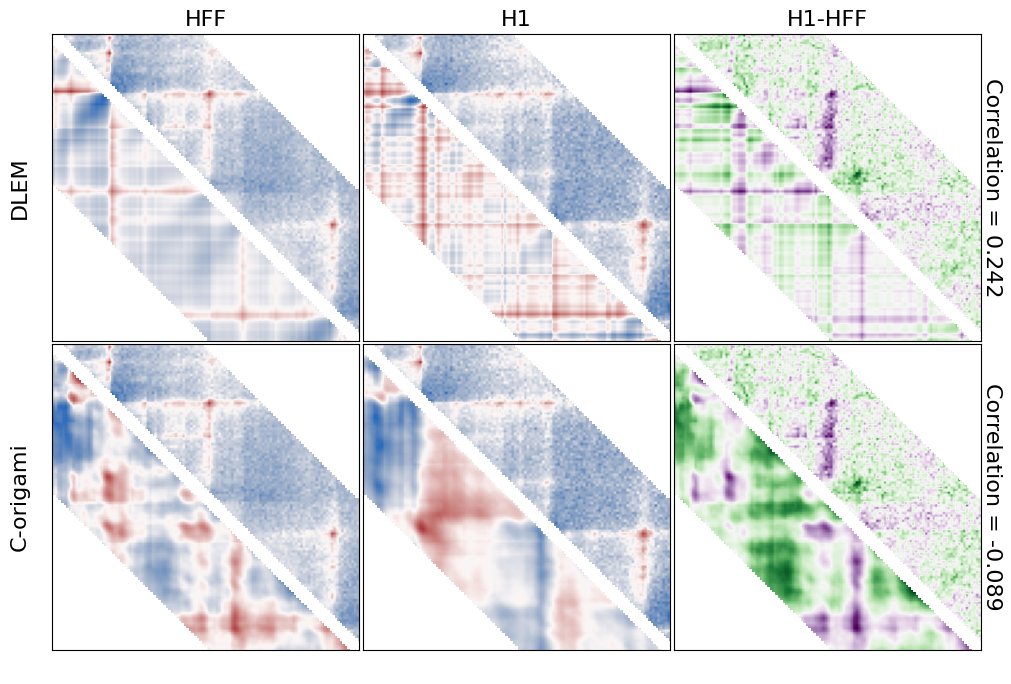

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                               gridspec_kw={'wspace':0.01, 'hspace':0.01})#, sharex='col', sharey='row')
color_map = "vlag"
color_map_diff = "PRGn"
plot_pred_data(map_hff, pred_hff, axes[0,0], cmap=color_map)
axes[0,0].set_title("HFF", fontsize=16)
axes[0,0].set_ylabel("DLEM", labelpad=-10, fontsize=16)
plot_pred_data(map_h1, pred_h1, axes[0,1], cmap=color_map)
axes[0,1].set_title("H1", fontsize=16)
plot_pred_data(map_diff, pred_diff, axes[0,2], cmap=color_map_diff)
axes[0,2].yaxis.set_label_position('right')
axes[0,2].set_ylabel(f'Correlation = {pred_corr:.3f}',rotation=-90, labelpad=15, fontsize=16)
axes[0,2].set_title("H1-HFF", fontsize=16)
plot_pred_data(map_hff, origami_hff, axes[1,0], cmap=color_map)
axes[1,0].set_ylabel("C-origami", labelpad=-10, fontsize=16)
plot_pred_data(map_h1, origami_h1, axes[1,1], cmap=color_map)
plot_pred_data(map_diff, origami_diff, axes[1,2], cmap=color_map_diff)
axes[1,2].yaxis.set_label_position('right')
axes[1,2].set_ylabel(f'Correlation = {origami_corr:.3f}',rotation=-90, labelpad=15, fontsize=16)

for ax in axes.flat:
    make_ticks_invisible(ax)
plt.tight_layout()